In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
import sys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from os import pardir

In [2]:
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import safe_mkdir

In [5]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir 

'/home2/s20321005/Thesis-Project/Data'

## Math

from Poisson eq.
\begin{aligned}
  \nabla^2\Phi(z, r, \phi) = \frac{\partial^2 \Phi}{\partial z^2}+\frac{1}{r^2}\frac{\partial \Phi}{\partial \phi^2} + \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

Assume axisymmetric potential, and can be decoupled
\begin{aligned}
  \Phi(z, r, \phi) =  \Phi(z, r) =  \Phi_z(z) + \Phi_r(r)
\end{aligned}

Therefore
\begin{aligned}
  \nabla^2\Phi(z, r, \phi)  = \frac{\partial^2 \Phi_z}{\partial z^2}+ \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

where (Buch et. al. [2019](https://iopscience.iop.org/article/10.1088/1475-7516/2019/04/026))
\begin{aligned}
  \mathcal{R} &= \frac{1}{(4\pi G)} \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) \\
    &= (3.4\pm 0.6)\times10^{-3} M_\odot /\text{pc}^3
\end{aligned}

and $\rho$ is divided into three parts
* Baryon, $\rho_i$
* Thin Dark Disk, $\rho_\text{DD}$
* Constant Local Halo Dark Matter $\rho_\text{DM}$


Using Bahcall Model for Baryon, for each components
\begin{aligned}
  \rho_i = \rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}
\end{aligned}
And total baryons
\begin{aligned}
  \rho_b = \sum_i^N\rho_i
\end{aligned}

For thin DD
\begin{aligned}
  \rho_\text{DD}(z) = \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right)
\end{aligned}

So,
\begin{aligned}
  \frac{\partial^2 \Phi_z}{\partial z^2} &= 4\pi G\rho_\text{eff} \\
  \frac{1}{4\pi G}\frac{\partial^2 \Phi_z}{\partial z^2} &= \sum_i^N\left[\rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}\right] + \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right) + \rho_\text{DM} - \mathcal{R}
\end{aligned}

# 1 Component

In [3]:
def sech(x):
    return 1/np.cosh(x)

def rhoDD(z, sigmaDD, hDD):
    return sigmaDD/(4*hDD)*sech(z/(2*hDD))**2

def rho_tot1(z, phi, rho1, sigmaz1, rhoDM, sigmaDD, hDD, R=3.4E-3):
    return rho1*np.exp(-phi/sigmaz1**2) + rhoDM + rhoDD(z, sigmaDD, hDD) - R

def f1(u, z, rho1, sigmaz1, rhoDM, sigmaDD, hDD, R=3.4E-3):
    G = 4.30091E-3 # pc/M_sun (km/s)^2
    return (u[1], 4*np.pi*G*rho_tot1(z, u[0], rho1, sigmaz1, rhoDM, sigmaDD, hDD, R))

In [4]:
# Test
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2

y0 = [Kz0, phi0]
zs = np.linspace(0, 1000, 1000)

rho1 = 0.0104 # Msun/pc^3
sigmaz1 = 3.7 # km/s
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 67.435 # pc
R = 3.4E-3 # Msun/pc^3
us = odeint(f1, y0, zs, args=(rho1, sigmaz1, rhoDM, sigmaDD, hDD, R))

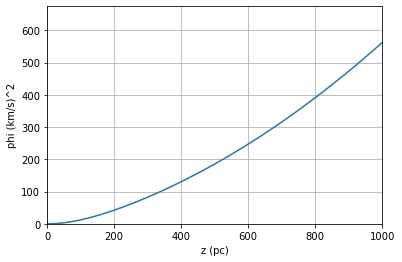

In [5]:
phi = us[:, 0]
plt.plot(zs, phi)
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.xlim(0, zs[-1])
plt.ylim(0, phi[-1]*1.2)
plt.grid()

(0.0, 1.1085274249713257)

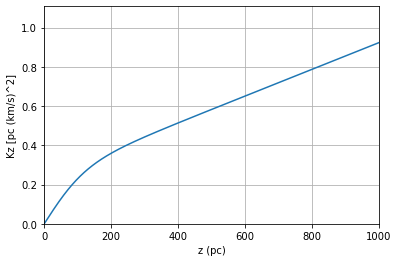

In [6]:
Kz = us[:, 1]
plt.plot(zs, Kz)
plt.xlabel("z (pc)")
plt.ylabel("Kz [pc (km/s)^2]")
plt.grid()
plt.xlim(0, zs[-1])
plt.ylim(0, Kz[-1]*1.2)

# Multi-components

In [7]:
def sech(x):
    return 1/np.cosh(x)

def rhoDD(z, sigmaDD, hDD):
    return sigmaDD/(4*hDD)*sech(z/(2*hDD))**2

def frho(rho0, phi, sigmaz ):
    return rho0*np.exp(-phi/sigmaz**2)

def rho_tot(z, phi, rhos, sigmaz, rhoDM, sigmaDD, hDD, R=3.4E-3):
    rho = np.array(list(map(lambda par: frho(par[0], phi, par[1]), zip(rhos, sigmaz))))
    return rho.sum() + rhoDM + rhoDD(z, sigmaDD, hDD) - R

def f(u, z, rhos, sigmaz, rhoDM, sigmaDD, hDD, R=3.4E-3):
    G = 4.30091E-3 # pc/M_sun (km/s)^2
    return (u[1], 4*np.pi*G*rho_tot(z, u[0], rhos, sigmaz, rhoDM, sigmaDD, hDD, R))

In [8]:
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2

y0 = [Kz0, phi0]
zs = np.linspace(0, 200, 1000)

rhos = np.array([0.0104, 0.0277, 0.0073]) # Msun/pc^3
sigmaz = np.array([3.7, 7.1, 22.1]) # km/s
rhoDM = 0 #0.016 # Msun/pc^3
sigmaDD = 10 # Msun/pc^2
hDD = 20 # pc
R = 0 # 3.4E-3 # Msun/pc^3
us = odeint(f, y0, zs, args=(rhos, sigmaz, rhoDM, sigmaDD, hDD, R))

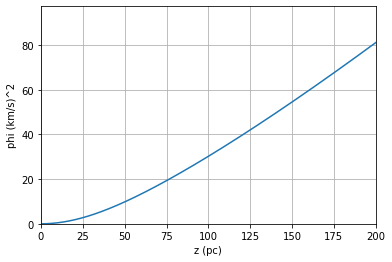

In [9]:
phi = us[:, 0]
plt.plot(zs, phi)
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.xlim(0, zs[-1])
plt.ylim(0, phi[-1]*1.2)
plt.grid()

(0.0, 0.659031221794448)

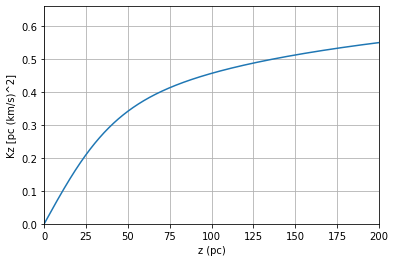

In [10]:
Kz = us[:, 1]
plt.plot(zs, Kz)
plt.xlabel("z (pc)")
plt.ylabel("Kz [pc (km/s)^2]")
plt.grid()
plt.xlim(0, zs[-1])
plt.ylim(0, Kz[-1]*1.2)

$\Phi(z)$ for all $z$ and if the middle planet is at $z_{0}$

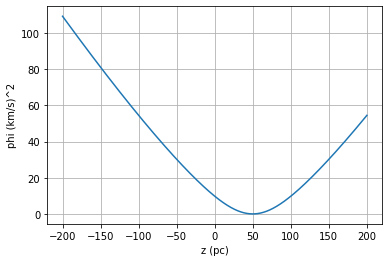

In [14]:
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2

y0 = [Kz0, phi0]
zmax = 200

rhos = np.array([0.0104, 0.0277, 0.0073]) # Msun/pc^3
sigmaz = np.array([3.7, 7.1, 22.1]) # km/s
rhoDM = 0 #0.016 # Msun/pc^3
sigmaDD = 10 # Msun/pc^2
hDD = 20 # pc
R = 0 # 3.4E-3 # Msun/pc^3
z0 = 50

zs = np.linspace(0, zmax+np.abs(z0), 1000)
us = odeint(f, y0, zs, args=(rhos, sigmaz, rhoDM, sigmaDD, hDD, R))

phi = us[:, 0]

phi_interp = interp1d(zs, phi, kind='cubic')
phi_z = lambda z, z0: phi_interp(np.abs(z-z0))

zs = np.linspace(-200, 200, 1000)
plt.plot(zs, phi_z(zs, z0))
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.grid()
plt.show()

# Number density

Eq (3.4) from [Schutz et. al (2019)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.081101)

\begin{aligned}
  \nu(z) &= \nu_0 \int_{\sqrt{2\Phi(z)}}^\infty \frac{2f_{0}(|w|)w \text{ d}w}{\sqrt{w^2-2\Phi(z)}}
\end{aligned}
and $f_{0}(|w|)$ is modelled as gaussian with zero mean and some std $\sigma_w$
\begin{aligned}
  f_{0}(|w|) \approx \mathcal{N}(|w|; 0, \sigma_w)
\end{aligned}

Integrated, becomes
\begin{aligned}
  \nu(z) &= \nu_0\exp{\left(-\frac{\Phi(z)}{\sigma^2_w}\right)}
\end{aligned}

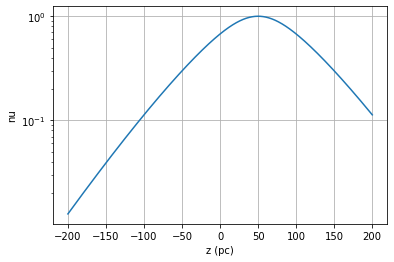

In [16]:
nu0 = 1
sigma_w = 5
nu = nu0*np.exp(-phi_z(zs, z0)/sigma_w**2)

plt.plot(zs, nu)
plt.xlabel("z (pc)")
plt.ylabel("nu")
plt.yscale("log")
plt.grid()
plt.show()

What if $f_0$ is a mixture of gaussians?
\begin{aligned}
  f_{0}(|w|) \approx \sum_i^Na_i\mathcal{N}(|w|; \mu_i, \sigma_i)
\end{aligned}

Where
\begin{align*}
 \int_{-\infty}^\infty f_{0}(|w|) \text{ d}w &= 1 \\
 \int_{-\infty}^\infty \sum_i^Na_i\mathcal{N}(|w|; \mu_i, \sigma_i) &=  1\\
 \sum_i^N a_i\int_{-\infty}^\infty \mathcal{N}(|w|; \mu_i, \sigma_i) &=  1\\
 \sum_i^N a_i &=  1\\
\end{align*}

Then, $\nu(z)$ becomes
\begin{aligned}
  \nu(z) &= \nu_0\sum_i^N\left[a_i\exp{\left(-\frac{\Phi(z)}{\sigma^2_{w,i}}\right)}\right]
\end{aligned}

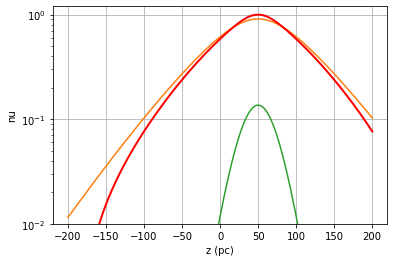

In [52]:
nu0 = 1
sigma_w = np.vstack(np.array([10, 5, 2]))
a_raw = np.vstack(np.array([-0.1, 2, 0.3]))
a = a_raw/np.sum(a_raw)

nu = nu0*np.sum(a*np.exp(-phi_z(zs, z0)/sigma_w**2), axis=0)


for ai, sigma_wi in zip(a, sigma_w):
    plt.plot(zs, nu0*ai*np.exp(-phi_z(zs, z0)/sigma_wi**2))
plt.xlabel("z (pc)")
plt.ylabel("nu")
plt.plot(zs, nu, c="r", lw=2)
plt.ylim(1E-2, nu0*1.2)
plt.yscale("log")
plt.grid()
plt.show()

# All Components

Baryonic components (compiled by [Schutz, K., Lin, T., Safdi, B. R., & Wu, C. L. (2018). Constraining a Thin Dark Matter Disk with G a i a. Physical review letters, 121(8), 081101](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.081101))

| Components               | density (Msun/pc^3) | sigma_z (km/s) |
| ------------------------ | ------------------- | -------------- |
| Molecular gas (H2)       | 0.0104 ± 0.00312    |  3.7 ± 0.2     |
| Cold atomic gas (HI(1))  | 0.0277 ± 0.00554    |  7.1 ± 0.5     |
| Warm atomic gas (HI(2))  | 0.0073 ± 0.00070    | 22.1 ± 2.4     |
| Hot ionized gas (HII)    | 0.0005 ± 0.00003    | 39.0 ± 4.0     |
| Giant stars              | 0.0006 ± 0.00006    | 15.5 ± 1.6     |
| MV < 3                   | 0.0018 ± 0.00018    |  7.5 ± 2.0     |
| 3 < MV < 4               | 0.0018 ± 0.00018    | 12.0 ± 2.4     |
| 4 < MV < 5               | 0.0029 ± 0.00029    | 18.0 ± 1.8     |
| 5 < MV < 8               | 0.0072 ± 0.00072    | 18.5 ± 1.9     |
| MV > 8 (M dwarfs)        | 0.0216 ± 0.00280    | 18.5 ± 4.0     |
| White dwarfs             | 0.0056 ± 0.00100    | 20.0 ± 5.0     |
| Brown dwarfs             | 0.0015 ± 0.00050    | 20.0 ± 5.0     |

let's create this table, and save it


In [14]:
# if you already have it, just skip to test with all components

table_dict = {
  "components": [
    "Molecular gas (H2)", 
    "Cold atomic gas (HI(1))",
    "Warm atomic gas (HI(2))",
    "Hot ionized gas (HII)",
    "Giant stars",
    "MV < 3",
    "3 < MV < 4",
    "4 < MV < 5",
    "5 < MV < 8",
    "MV > 8",
    "White dwarfs",
    "Brown dwarfs"
    ],
    "rho": [
       0.0104,
       0.0277,
       0.0073,
       0.0005,
       0.0006,
       0.0018,
       0.0018,
       0.0029,
       0.0072,
       0.0216,
       0.0056,
       0.0015
    ],
    "e_rho": [0.00312, 0.00554, 0.00070, 0.00003, 0.00006, 0.00018, 0.00018, 0.00029, 0.00072, 0.00280, 0.00100, 0.00050],
    "sigma_z": [3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 18.0, 18.5, 18.5, 20.0, 20.0],
    "e_sigma_z": [0.2, 0.5, 2.4, 4.0, 1.6, 2.0, 2.4, 1.8, 1.9, 4.0, 5.0, 5.0]
  }

df = vaex.from_dict(table_dict)
df

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [58]:
name = "Baryon"
data_dir = join(root_data_dir, name)
safe_mkdir(data_dir)

Directory /home2/s20321005/Thesis-Project/Data/Baryon already exist. Good to go!


In [15]:
df.export(join(data_dir, "baryon.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.10s =  0.0m =  0.0h
 

# Test run with all components

In [59]:
def sech(x):
    return 1/np.cosh(x)

def rhoDD(z, sigmaDD, hDD):
    return sigmaDD/(4*hDD)*sech(z/(2*hDD))**2

def frho(rho0, phi, sigmaz ):
    return rho0*np.exp(-phi/sigmaz**2)

def rho_tot(z, phi, rhos, sigmaz, rhoDM, sigmaDD, hDD, R=3.4E-3):
    rho = np.array(list(map(lambda par: frho(par[0], phi, par[1]), zip(rhos, sigmaz))))
    return rho.sum() + rhoDM + rhoDD(z, sigmaDD, hDD) - R

def f(u, z, rhos, sigmaz, rhoDM, sigmaDD, hDD, R=3.4E-3):
    G = 4.30091E-3 # pc/M_sun (km/s)^2
    return (u[1], 4*np.pi*G*rho_tot(z, u[0], rhos, sigmaz, rhoDM, sigmaDD, hDD, R))

def nu(phi, sigma_w):
    return np.exp(-phi/sigma_w**2)

In [60]:
name = "Baryon"
data_dir = join(root_data_dir, name)
data_dir

'/home2/s20321005/Thesis-Project/Data/Baryon'

In [61]:
# load baryons components
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [65]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 65 # pc
nu0 = 1

# initial values
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2
R = 3.4E-3 
z0 = -50 # pc
zmax = 200 # pc
y0 = [Kz0, phi0]
zs = np.linspace(0, zmax+abs(z0), 1000)
us = odeint(f, y0, zs, args=(rhos, sigmaz, rhoDM, sigmaDD, hDD, R))

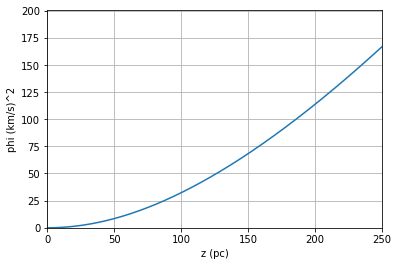

In [66]:
phi = us[:, 0]
plt.plot(zs, phi)
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.xlim(0, zs[-1])
plt.ylim(0, phi[-1]*1.2)
plt.grid()

(0.0, 1.3527761844232413)

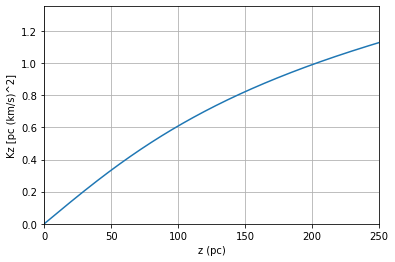

In [67]:
Kz = us[:, 1]
plt.plot(zs, Kz)
plt.xlabel("z (pc)")
plt.ylabel("Kz [pc (km/s)^2]")
plt.grid()
plt.xlim(0, zs[-1])
plt.ylim(0, Kz[-1]*1.2)

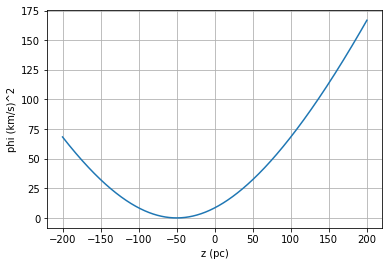

In [68]:
phi = us[:, 0]

phi_interp = interp1d(zs, phi, kind='cubic')
phi_z = lambda z, z0: phi_interp(np.abs(z-z0))

zs = np.linspace(-200, 200, 1000)
plt.plot(zs, phi_z(zs, z0))
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.grid()
plt.show()

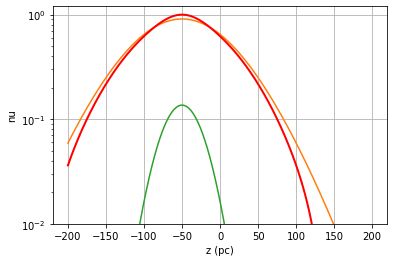

In [70]:
nu0 = 1
sigma_w = np.vstack(np.array([10, 5, 2]))
a_raw = np.vstack(np.array([-0.1, 2, 0.3]))
a = a_raw/np.sum(a_raw)

nu = nu0*np.sum(a*np.exp(-phi_z(zs, z0)/sigma_w**2), axis=0)

for ai, sigma_wi in zip(a, sigma_w):
    plt.plot(zs, nu0*ai*np.exp(-phi_z(zs, z0)/sigma_wi**2))
plt.xlabel("z (pc)")
plt.ylabel("nu")
plt.plot(zs, nu, c="r", lw=2)
plt.ylim(1E-2*nu0, nu0*1.2)
plt.yscale("log")
plt.grid()
plt.show()

Compiling and creating $\nu^{\text{mod}}(\theta)$ function

all in one

In [12]:
# from operator import itemgetter
# from scipy.interpolate import interp1d
# import numpy as np
# from scipy.integrate import odeint

# def sech(x):
#     return 1/np.cosh(x)

# def rhoDD(z, sigmaDD, hDD):
#     return sigmaDD/(4*hDD)*sech(z/(2*hDD))**2

# def frho(rho0, phi, sigmaz ):
#     return rho0*np.exp(-phi/sigmaz**2)

# def rho_tot(z, phi, rhos, sigmaz, rhoDM, sigmaDD, hDD, R=3.4E-3):
#     rho = np.array(list(map(lambda par: frho(par[0], phi, par[1]), zip(rhos, sigmaz))))
#     return rho.sum() + rhoDM + rhoDD(z, sigmaDD, hDD) - R

# def f(u, z, rhos, sigmaz, rhoDM, sigmaDD, hDD, R=3.4E-3):
#     G = 4.30091E-3 # pc/M_sun (km/s)^2
#     return (u[1], 4*np.pi*G*rho_tot(z, u[0], rhos, sigmaz, rhoDM, sigmaDD, hDD, R))

# def phi_mod(zz, **theta):
#     args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'zsun', 'R')
#     rhos, sigmaz, rhoDM, sigmaDD, hDD, zsun, R = itemgetter(*args)(theta)
#     res = 1000
#     if 'res' in theta:
#         res = theta['res']
#     phi0 = 0 # (km/s)^2
#     Kz0 = 0 # pc (km/s)^2

#     y0 = [Kz0, phi0]
#     zmax = np.max(np.abs(zz+zsun))
#     zs = np.linspace(0, zmax, res)
#     us = odeint(f, y0, zs, args=(rhos, sigmaz, rhoDM, sigmaDD, hDD, R))
#     phi = us[:, 0]
#     phi_interp = interp1d(zs, phi, kind='cubic')
#     phi_z = lambda z, zsun: phi_interp(np.abs(z+zsun))
#     return phi_z(zz, zsun)

# def nu_mod(zz, **theta):
#     args = ('sigma_w', 'a', 'nu0')
#     sigma_w, a, nu0 = itemgetter(*args)(theta)
#     sigma_w = np.vstack(sigma_w)
#     a_raw = np.vstack(a)
#     a = a_raw/np.sum(a_raw)
#     nu = nu0*np.sum(a*np.exp(-phi_mod(zz, **theta)/sigma_w**2), axis=0)
#     nu = np.abs(nu)
#     return nu

In [13]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 1
zsun = -50
sigma_w = np.array([10, 5, 2])
a_raw = np.array([1, 2, 0.3])
w0 = 0.5

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, nu0=nu0, zsun=zsun, R=R, w0=w0, sigma_w=sigma_w, a=a_raw)

zz = np.linspace(-200, 200, 50)
sigma_v = 5
nu = nu_mod(zz, **theta)
nu

array([0.05351229, 0.05872495, 0.0644004 , 0.07058779, 0.07734642,
       0.08474849, 0.09288238, 0.10185648, 0.11180343, 0.12288477,
       0.13529555, 0.1492687 , 0.16507837, 0.18304169, 0.2035177 ,
       0.2269024 , 0.25361821, 0.28409637, 0.31875048, 0.35794038,
       0.40192706, 0.4508248 , 0.50456482, 0.56289552, 0.62543759,
       0.69174842, 0.76118209, 0.83213646, 0.90046511, 0.95797078,
       0.99342026, 0.99761574, 0.96934784, 0.91626842, 0.84970988,
       0.77888168, 0.70885084, 0.64168087, 0.57815263, 0.5187304 ,
       0.46381277, 0.41369047, 0.36848002, 0.32811047, 0.2923531 ,
       0.26086833, 0.23325219, 0.20907503, 0.18791023, 0.16935397])

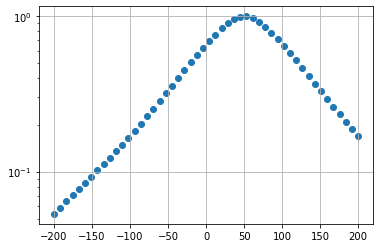

In [14]:
plt.scatter(zz, nu)
plt.yscale("log")
plt.grid()

save the relevant functions to utils.py

# Test function from utils.py

In [6]:
from utils import nu_mod

In [7]:
name = "Baryon"
data_dir = join(root_data_dir, name)
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [26]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 1
zsun = -0
sigma_w = np.array([20])
a_raw = np.array([1])
w0 = 0.5

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, nu0=nu0, zsun=zsun, R=R, w0=w0, sigma_w=sigma_w, a=a_raw)

zz = np.linspace(-1000, 1000, 1000)
sigma_v = 5
nu = nu_mod(zz, **theta)
# filter all z for which nu > 0.2
zb = zz[nu < 0.2]
nub = nu[nu < 0.2]

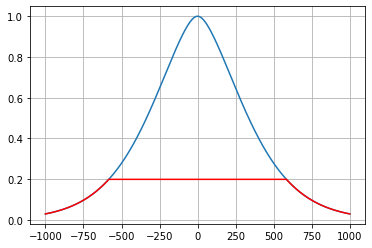

In [27]:
plt.plot(zz, nu)
plt.plot(zb, nub, c="r")
plt.grid()